### 1. Load data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import math
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk

/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/mazerl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_data = load_from_disk(
        "/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/code-repo/dataset/even_label/11x11_train.hf"
    ).with_format("torch")

print(loaded_data.shape)
print(loaded_data[0])

(300000, 3)
{'data': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'filename': '11HnKgridsize_1_step0_DOWN', 'label': tensor(4)}


In [3]:
batch_size = 4
train_set_size = math.floor(0.8*loaded_data.shape[0])
train_set, val_set = torch.utils.data.random_split(loaded_data, [train_set_size, loaded_data.shape[0] - train_set_size])
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
testLoader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False)

classes = ('END', 'LEFT', 'RIGHT', 'UP', 'DOWN')

test the dataloader

(tensor(2), tensor(4), tensor(4), tensor(2))

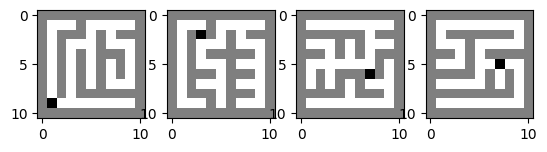

In [4]:
# test the dataloader
dataiter = iter(trainLoader)
this_iter = next(dataiter)
this_iter['data'], this_iter['label']
# mazes, filenames, labels = next(dataiter)
# mazes
# this_iter

fig, axes = plt.subplots(1,4)
axes[0].imshow(this_iter['data'][0].numpy(), cmap='binary')
axes[1].imshow(this_iter['data'][1].numpy(), cmap='binary')
axes[2].imshow(this_iter['data'][2].numpy(), cmap='binary')
axes[3].imshow(this_iter['data'][3].numpy(), cmap='binary')

this_iter['label'][0], this_iter['label'][1], this_iter['label'][2], this_iter['label'][3]

### 2. Define a Convolutional Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x


net = Net()
print(net)
n = 11
summary(net, (1,n,n))

Net(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 4, 7, 7]             104
            Conv2d-2              [-1, 8, 5, 5]             296
            Conv2d-3             [-1, 16, 3, 3]           1,168
            Linear-4                  [-1, 120]          17,400
            Linear-5                   [-1, 84]          10,164
            Linear-6                    [-1, 5]             425
Total params: 29,557
Trainable params: 29,557
Non-trainable params: 0
--------------------------------------------------

### 3. Define a Loss function and optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [9]:

losslist = []
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, current_data in enumerate(trainLoader, 0):
    # for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # print(current_data)
        inputs = current_data["data"].float().reshape(-1, 1, n, n)
        # print(inputs.shape)
        labels = current_data["label"]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losslist.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.610
[1,  4000] loss: 1.609
[1,  6000] loss: 1.608
[1,  8000] loss: 1.520
[1, 10000] loss: 1.063
[1, 12000] loss: 0.971
[1, 14000] loss: 0.861
[1, 16000] loss: 0.800
[1, 18000] loss: 0.752
[1, 20000] loss: 0.690
[1, 22000] loss: 0.618
[1, 24000] loss: 0.537
[1, 26000] loss: 0.471
[1, 28000] loss: 0.441
[1, 30000] loss: 0.377
[1, 32000] loss: 0.359
[1, 34000] loss: 0.343
[1, 36000] loss: 0.324
[1, 38000] loss: 0.307
[1, 40000] loss: 0.292
[1, 42000] loss: 0.276
[1, 44000] loss: 0.280
[1, 46000] loss: 0.272
[1, 48000] loss: 0.257
[1, 50000] loss: 0.249
[1, 52000] loss: 0.243
[1, 54000] loss: 0.237
[1, 56000] loss: 0.226
[1, 58000] loss: 0.234
[1, 60000] loss: 0.224
[2,  2000] loss: 0.225
[2,  4000] loss: 0.213
[2,  6000] loss: 0.215
[2,  8000] loss: 0.200
[2, 10000] loss: 0.202
[2, 12000] loss: 0.196
[2, 14000] loss: 0.200
[2, 16000] loss: 0.193
[2, 18000] loss: 0.199
[2, 20000] loss: 0.185
[2, 22000] loss: 0.181
[2, 24000] loss: 0.186
[2, 26000] loss: 0.177
[2, 28000] 

Save the trained model

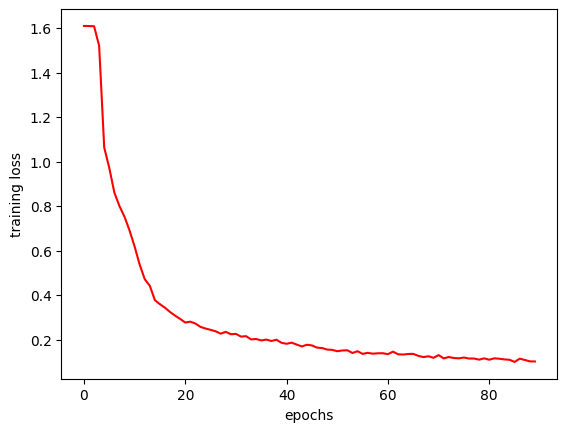

In [10]:
import matplotlib.pyplot as plt

plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(losslist,color='red')
plt.show()

In [11]:
PATH = './maze_net11x11_even_label_ver2.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

display an image from the test set to get familiar

load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so)

(tensor(3), tensor(0), tensor(2), tensor(0))

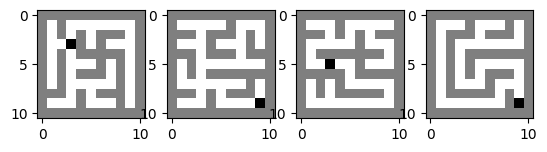

In [12]:
dataiter_test = iter(testLoader)
this_iter_test = next(dataiter_test)

fig, axes = plt.subplots(1,4)
axes[0].imshow(this_iter_test['data'][0].numpy(), cmap='binary')
axes[1].imshow(this_iter_test['data'][1].numpy(), cmap='binary')
axes[2].imshow(this_iter_test['data'][2].numpy(), cmap='binary')
axes[3].imshow(this_iter_test['data'][3].numpy(), cmap='binary')

this_iter_test['label'][0], this_iter_test['label'][1], this_iter_test['label'][2], this_iter_test['label'][3]

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(this_iter_test["data"].float().reshape(-1,1,n,n))
outputs

tensor([[-10.3671,  -2.6371,  -2.6879,   7.7606,   8.5923],
        [ 28.3387, -27.9146,  13.9539, -33.2778,  16.4257],
        [ -5.2029,   2.6021,   4.1563,  -0.3940,  -0.3331],
        [ 34.3470, -33.4735,  19.8698, -39.6061,  13.7072]],
       grad_fn=<AddmmBackward0>)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  DOWN  END   RIGHT END  


Let us look at how the network performs on the whole dataset.

In [16]:
import numpy as np
from sklearn.metrics import f1_score

In [17]:
correct = 0
total = 0

f1_true = None
f1_predicted = None

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for current_data in testLoader:
        mazes = current_data['data'].float().reshape(-1,1,n,n)
        labels = current_data['label']
        # calculate outputs by running images through the network
        outputs = net(mazes)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if f1_true is None:
            f1_true = labels.detach().numpy()
            f1_predicted = predicted.detach().numpy()
        else:
            f1_true = np.concatenate((f1_true, labels.detach().numpy()))
            f1_predicted = np.concatenate((f1_predicted, predicted.detach().numpy()))

print(f'Accuracy of the network on the test mazes: {100 * correct // total} %')

# F1 score
score = f1_score(f1_true, f1_predicted, average="macro")
print(f"The F1 Score is: {score}")

Accuracy of the network on the test mazes: 93 %
The F1 Score is: 0.9397174492362147


Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for current_data in testLoader:
        mazes = current_data['data'].float().reshape(-1,1,n,n)
        labels = current_data['label']
        outputs = net(mazes)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            # print(label, prediction)
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# print(total_pred)

Accuracy for class: END   is 100.0 %
Accuracy for class: LEFT  is 90.3 %
Accuracy for class: RIGHT is 91.2 %
Accuracy for class: UP    is 92.4 %
Accuracy for class: DOWN  is 95.8 %
